# Smooth and flux-calibrate the input spectra to match the ETC.

The goal of this notebook is to see if we can reproduce the NIRSpec/prism spectra produced by the JWST/ETC (which are in e-/s) by smoothing and "unfluxing" (i.e., applying the throughput curves) the input spectra, which are in mJy.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import fitsio
from astropy.table import Table

from prospect.utils.smoothing import smoothspec

In [2]:
plt.style.use('seaborn-talk')
%matplotlib inline

In [3]:
jwstdir = os.path.join( os.getenv('IM_PROJECTS_DIR'), 'jwstclusters', 'etc' )
pandeia_dir = os.path.join( os.getenv('IM_DATA_DIR'), 'pandeia_data-1.0' )

### Read the instrumental resolution. 

In [4]:
dispfile = os.path.join(pandeia_dir, 'jwst', 'nirspec', 'dispersion', 'jwst_nirspec_prism_disp.fits')
print('Reading {}'.format(dispfile))
disp = Table.read(dispfile)

Reading /Users/ioannis/research/data/pandeia_data-1.0/jwst/nirspec/dispersion/jwst_nirspec_prism_disp.fits


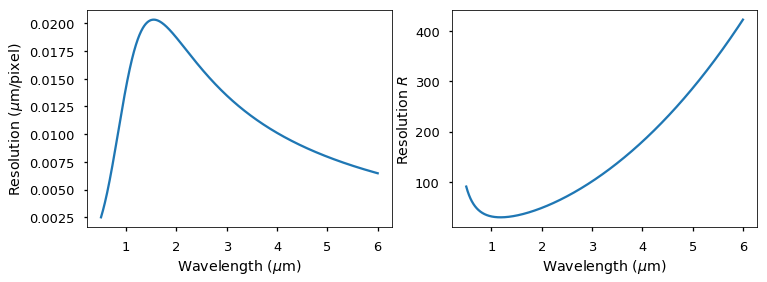

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(disp['WAVELENGTH'], disp['DLDS'])
ax[0].set_xlabel('Wavelength ($\mu$m)')
ax[0].set_ylabel('Resolution ($\mu$m/pixel)')

ax[1].plot(disp['WAVELENGTH'], disp['R'])
ax[1].set_xlabel('Wavelength ($\mu$m)')
ax[1].set_ylabel('Resolution $R$')

### Get the total throughput.

Reading /Users/ioannis/research/data/pandeia_data-1.0/jwst/nirspec/blaze/jwst_nirspec_prism_speceff.fits
Reading /Users/ioannis/research/data/pandeia_data-1.0/jwst/nirspec/filters/jwst_nirspec_clear_trans.fits
Reading /Users/ioannis/research/data/pandeia_data-1.0/jwst/nirspec/optical/jwst_nirspec_mos_internaloptics_throughput.fits
Reading /Users/ioannis/research/data/pandeia_data-1.0/jwst/telescope/jwst_telescope_ote_thruput.fits


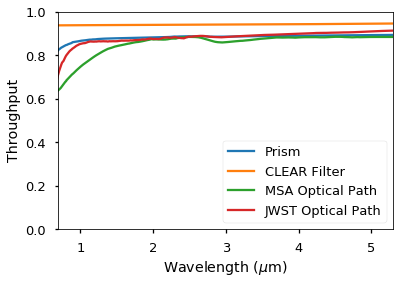

In [6]:
thru_prism = os.path.join(pandeia_dir, 'jwst', 'nirspec', 'blaze', 
                          'jwst_nirspec_prism_speceff.fits') # prism throughput
thru_clear = os.path.join(pandeia_dir, 'jwst', 'nirspec', 'filters', 
                          'jwst_nirspec_clear_trans.fits') # CLEAR filter throughput 
thru_optics = os.path.join(pandeia_dir, 'jwst', 'nirspec', 'optical', 
                           'jwst_nirspec_mos_internaloptics_throughput.fits') # NIRSpec MSA optical path
thru_telescope = os.path.join(pandeia_dir, 'jwst', 'telescope', 
                              'jwst_telescope_ote_thruput.fits') # JWST optical path
labels = ['Prism', 'CLEAR Filter', 'MSA Optical Path', 'JWST Optical Path']

thru = []

for lab, thrufile in zip( labels, (thru_prism, thru_clear, thru_optics, thru_telescope) ):
    print('Reading {}'.format(thrufile))
    tt = Table(fitsio.read(thrufile, ext=1, upper=True))
    thru.append(tt)
    plt.plot(tt['WAVELENGTH'], tt['THROUGHPUT'], label=lab)
plt.xlim(0.7, 5.3)
plt.ylim(0, 1)
plt.ylabel('Throughput')
plt.xlabel('Wavelength ($\mu$m)')
plt.legend(loc='lower right')    

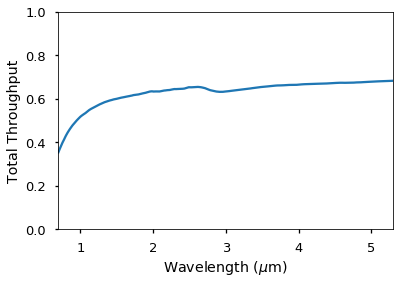

In [7]:
throughput_wave = thru[1]['WAVELENGTH']
throughput = np.ones_like(throughput_wave)
for tt in thru:
    throughput *= np.interp(throughput_wave, tt['WAVELENGTH'], tt['THROUGHPUT'])
plt.plot(throughput_wave, throughput)
plt.xlim(0.7, 5.3)
plt.ylim(0, 1)
plt.ylabel('Total Throughput')
plt.xlabel('Wavelength ($\mu$m)')

In [8]:
suffix = '03'

In [44]:
outfile = os.path.join(jwstdir, 'output', suffix, 'lineplot', 'lineplot_extracted_flux.fits')
tt = Table(fitsio.read(outfile, ext=1, upper=True))
dw = np.diff(tt['WAVELENGTH'])
dw = np.hstack( (dw[0], dw) )

In [19]:
infile = os.path.join(jwstdir, 'input', 'modelspec_{}.txt'.format(suffix))
inwave, influx = np.loadtxt(infile, unpack=True)

(1, 5)

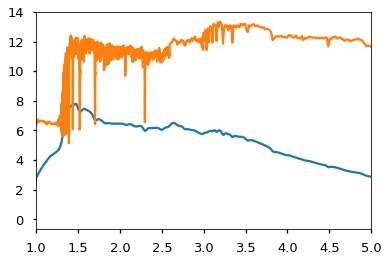

In [45]:
plt.plot(tt['WAVELENGTH'], tt['EXTRACTED_FLUX'] * tt['WAVELENGTH'])
#plt.plot(tt['WAVELENGTH'], tt['EXTRACTED_FLUX'])
plt.plot(inwave, influx * 1e3)
plt.xlim(1, 5)

In [10]:
smoothflux = smoothspec(inwave, influx, resolution=disp['DLDS'].data, smoothtype='lambda', 
                        outwave=tt['WAVELENGTH'], fftsmooth=False)

#plt.plot(inwave, influx)
plt.xlim(0.7, 5.3)

ValueError: operands could not be broadcast together with shapes (1001,) (2,) 

In [ ]:
import pysynphot

In [ ]:
help(pysynphot)